# python launcher

In [289]:
import sys
if 'ipykernel_launcher.py' not in sys.argv[0]:
    manual = False
    scenario = sys.argv[1]
else:
    manual = True
    scenario = 'intermodal'
    %matplotlib inline

In [290]:
#%matplotlib inline

In [291]:
import pandas as pd

# import 

In [292]:
import geopandas as gpd
import pandas as pd
import numpy as np

work_path = r'../../../'
quetzal_path = work_path + r'quetzal_santo_domingo/'

import sys
sys.path.insert(0, '../../../quetzal/')

from quetzal.model import stepmodel
from quetzal.io import display

In [293]:
distributed =  stepmodel.read_zip(quetzal_path + 'model/transport/distribution.zip')

zones: 100%|██████████| 29/29 [00:00<00:00, 169.23it/s]     


In [294]:
car =  stepmodel.read_zip(quetzal_path + 'model/transport/car_pathfinder.zip')
pt = stepmodel.read_zip(quetzal_path + 'model/'+ scenario +'/pt_pathfinder.zip')

zones: 100%|██████████| 26/26 [00:02<00:00, 10.89it/s]       


In [295]:
sm = pt.copy()
sm.car_los = car.car_los

sm.road_nodes = car.road_nodes
sm.road_links = car.road_links

In [296]:
sm.volumes = distributed.volumes

# prep

In [297]:
self = sm
for value in ['length']:
    value_dict = self.road_links[value].to_dict()
    self.car_los[value] = self.car_los['link_path'].apply(
        lambda p: sum([value_dict[l] for l in p])
    ) 

# Utility parameters

In [298]:
parameter_frame = pd.read_excel(quetzal_path + r'inputs/parametros.xlsx').set_index(['category','parameter'])
for c in parameter_frame.columns:
    parent = parameter_frame[c][('general', 'parent')]
    try:
        parent = parent.iloc[0]
    except AttributeError:# 'str' object has no attribute 'iloc'
        pass
    parameter_frame[c] = parameter_frame[c].fillna(parameter_frame[parent])
var = parameter_frame[scenario]

year = int(var['general', 'year'])

In [299]:
var

category                 parameter          
PARAMETROS DE ESCENARIO  NaN                                  NaN
general                  parent                 ambicioso_sitp_30
                         year                                2030
                         freeze_modal_split                 false
                         freeze_distribution                false
                                                      ...        
                         footpath_speed                       3.4
                         short_leg_speed                      4.4
                         long_leg_speed                        12
                         n_ntlegs                              10
                         ntleg_threshold                      300
Name: intermodal, Length: 105, dtype: object

# volumes

In [300]:
if var['general','freeze_distribution'].iloc[0].lower() == 'true':
    sm.volumes['car'] = sm.volumes['survey_car']
    sm.volumes['nocar'] = sm.volumes['survey_pt'] + sm.volumes['survey_walk']
    delta = year - 2018
    for segment in ['car', 'nocar']:
        sm.volumes[segment] = sm.volumes[segment]  * np.power(sm.volumes['growth'], delta)
else :
    sm.volumes[['car', 'nocar']] = sm.volumes[['car' + str(year), 'nocar' + str(year)]]

In [301]:
car_speed = float(var['speed']['car'])
gas_per_km = float(var['general']['gas_per_km']) # gal US per km (1 US gal= 3.7L)
gas_price = float(var['general']['gas_price'])# DOP per gal US
price_per_m =  gas_per_km * gas_price / 1000

# Fares

## PT fares

In [320]:
# Cálculo de tarifas según número de transferencias permitidas

for t in [0,1,2,3,4,5,'n']:
    name = 'f' + str(t)

    if t!='n':
        var['transfers', name] = t
    else:
        var['transfers', name] = 10

    price = min(var['base']['fx'] + (var['transfers'][name]*var['add']['fx']), var['max']['fx'])
    var['price', name] = price

# OJO: Solo para escenarios tarifarios -> OPRET se integra, respetando gratuidad entre metro-teleferico

var['price','opret'] = var['base']['fx']

In [321]:
fare_attributes = pd.DataFrame(
    {
    'price': var['price'],
    'transfers': var['transfers']
    }
)
fare_attributes.index.name = 'fare_id'
fare_attributes.reset_index(inplace=True)
fare_attributes[['price', 'transfers']] = fare_attributes[['price', 'transfers']].astype(float)
fare_attributes.loc[fare_attributes['fare_id'] == 'integrated', 'transfers'] = np.inf

# CHANGE TO TRUE TO TEST FARES | FALSE FOR THE FORMER BEHAVIOUR
add_custom_fare_attributes = False
#TODO change that so it is automated somehow
if add_custom_fare_attributes:
    fare_attributes = fare_attributes.append(pd.Series({'fare_id': 'direct', 'price': 25, 'transfers': 0}), ignore_index=True)
    fare_attributes = fare_attributes.append(pd.Series({'fare_id': 'opret', 'price': 20, 'transfers': np.inf}), ignore_index=True)
fare_attributes

,fare_id,price,transfers
0,bus,15.0,0.0
1,concho,35.0,0.0
2,express_bus,30.0,0.0
3,f0,35.0,0.0
4,f1,50.0,1.0
5,f2,65.0,2.0
6,f3,80.0,3.0
7,f4,80.0,4.0
8,f5,80.0,5.0
9,fn,80.0,10.0


In [304]:
left = left = var['fare_id'].apply(lambda s: [item.strip() for item in  s.split(',')]).explode().reset_index()
left.columns = ['route_type', 'fare_id']

#TODO change that so it is automated somehow
if add_custom_fare_attributes:
    left = pd.concat(
        [
            left, 
            left.loc[left['fare_id']=='integrated'].replace('integrated', 'direct'),
            left.loc[left['route_type'].isin(['subway'])].replace('integrated', 'opret')
        ]
    )


In [305]:
right = pt.lines[['route_type', 'route_id']]

In [306]:
fare_rules = pd.merge(left, right)[['fare_id', 'route_id']]
fare_rules.head()

,fare_id,route_id
0,concho,CP_C100_1
1,concho,CP_C100_2
2,concho,CP_C101E_1
3,concho,CP_C101E_2
4,concho,CP_C102_1


In [307]:
fare_attributes['agency_id'] = 'intrant'

In [308]:
sm.links['agency_id'] = 'intrant'
sm.nodes['zone_id'] = 0

In [309]:
sm.fare_rules = fare_rules
sm.fare_attributes = fare_attributes
sm.compute_arod_list()


In [310]:
# FORMER FARES
# sm.analysis_pt_fare(od_fares=False) 

# TEST

In [311]:
forbidden = {
    'f0': {'f1', 'f2', 'f3', 'f4', 'f5'},
    'f1': {'f0', 'f2', 'f3', 'f4', 'f5'},
    'f2': {'f0', 'f1', 'f3', 'f4', 'f5'},
    'f3': {'f0', 'f1', 'f2', 'f4', 'f5'},
    'f4': {'f0', 'f1', 'f2', 'f3', 'f5'},
    'f5': {'f0', 'f1', 'f2', 'f3', 'f4'},
} # fares that are irrelevant when consecutive

In [312]:
# NEW FARES
from quetzal.engine import fares
from imp import reload
reload(fares)
def compute_route_fares(self, consecutive=False):
    transfers = self.fare_attributes.set_index('fare_id')['transfers'].to_dict()
    price = self.fare_attributes.set_index('fare_id')['price'].to_dict()
    route_fares_dict = self.fare_rules.groupby('route_id')['fare_id'].agg(frozenset).to_dict()
    fare_options = [fares.get_fare_options(arod_list, route_fares_dict) for arod_list in sm.pt_los['arod_list']]
    unique_fare_options = set(fare_options)
    print(len(unique_fare_options))
    cheapest_breakdown_dict = {
        fo : fares.get_cheapest_breakdown(
            fares.get_breakdown_options(fo, transfers, price, forbidden=forbidden)
        )
        for fo in unique_fare_options
    }
    self.pt_los['route_fares'] = [cheapest_breakdown_dict[fo] for fo in fare_options]
    
compute_route_fares(sm)
sm.pt_los['price'] = sm.pt_los['route_fares'].apply(lambda breakdown: sum(breakdown.values()))

495


In [313]:
sm.pt_los[['route_fares', 'price']]

,route_fares,price
0,{},0.0
1,{},0.0
2,{},0.0
3,{},0.0
4,{},0.0
...,...,...
67,{'f2': 65.0},65.0
68,{'f2': 65.0},65.0
80,{'f2': 65.0},65.0
81,{'f2': 65.0},65.0


In [319]:
if manual:
    sm.pt_los.loc[~sm.pt_los.all_walk][['arod_list','route_fares','price']].to_excel(r'../../model/latest/test_'+scenario+'.xlsx')

## car fares

In [232]:
# length
self = sm
sm.road_links['toll'] = 0

In [233]:
self.car_los['price'] = self.car_los['length'] * price_per_m #+ self.car_los['toll']

# Time

## walk_time

In [234]:
short_leg_speed = float(var['general']['short_leg_speed'])
long_leg_speed = float(var['general']['long_leg_speed'])
threshold= float(var['general']['ntleg_threshold'])
footpath_speed= float(var['general']['footpath_speed'])
n_ntlegs = int(var['general']['n_ntlegs'])

In [235]:
sm.footpaths['time'] = sm.footpaths['length']  / 1000 * 3600 / footpath_speed
#sm.zone_to_transit['time'] = sm.zone_to_transit['distance']  / 1000 * 3600 / short_leg_speed
#sm.zone_to_road['time'] = sm.zone_to_road['distance']  / 1000 * 3600 / short_leg_speed

In [236]:
sm.preparation_ntlegs(
    n_ntlegs=n_ntlegs,
    short_leg_speed=short_leg_speed,
    long_leg_speed=long_leg_speed,
    zone_to_road=True,
)

## car_time

In [237]:
sm.road_links['speed'] = car_speed
sm.road_links['time'] = sm.road_links['length'] / 1000 * 3600 / sm.road_links['speed']

In [238]:
sm.zone_to_road  = car.zone_to_road

In [239]:
sm.analysis_car_time()
sm.analysis_car_length()

## pt_time

In [240]:
from shapely import geometry
def straight_length(ls):
    return geometry.LineString([list(ls.coords)[0],  list(ls.coords)[-1]]).length

In [241]:
sm.links['length'] = sm.links['geometry'].apply(straight_length)

In [242]:
if False:
    sm.links['speed'] = link_speed
    sm.links.loc[sm.links['route_type'] == 'subway', 'speed'] = metro_speed
    sm.links['time'] =  sm.links['length'] / 1000 * 3600 / sm.links['speed']

In [243]:
sm.analysis_pt_time(boarding_time=0)
sm.analysis_pt_length()

# transfers

In [244]:
sm.car_los['ntransfers'] = 0
sm.pt_los['ntransfers'] = sm.pt_los['alighting_links'].apply(len)

# route_types

In [245]:
mode_hierarchy = ['car', 'subway', 'tram',  'gondola', 'express_bus', 'bus', 'minibus', 'concho', 'walk']

In [246]:
sm.los = sm.pt_los
sm.analysis_pt_route_type(hierarchy=mode_hierarchy)
sm.analysis_car_route_type()

In [247]:
sm.lighten_pt_los()
sm.analysis_pt_los()
sm.lighten_car_los()
sm.analysis_car_los()
sm.los = pd.concat([sm.car_los, sm.pt_los]).reset_index(drop=True)

path_analysis: 100%|██████████| 123344/123344 [00:03<00:00, 39464.85it/s]


In [248]:
#sm.los.dropna(axis=1, inplace=True)

# UTILITY

In [249]:
loc = (sm.los['route_type'] == 'walk') & (sm.los['time'] > 1800)
sm.los.loc[loc, 'price'] = 100

In [250]:
route_types = set(sm.links['route_type'].unique()).union({'car', 'walk'})

In [251]:
# Average
sm.preparation_logit(
    mode=1, 
    pt_mode=0.5, 
    pt_path=0.2, 
    time=-1 / 3600,
    price= -1 / 50,
    transfers=-0.2,
    segments=['car', 'nocar'],
)

In [252]:
sm.mode_utility[['car', 'nocar']] = 0
sm.mode_utility.loc[['car'], ['nocar', 'car']] = [-100, 0.5] # [-100, 0] 
sm.mode_utility.loc[['minibus', 'concho'], ['nocar', 'car']] = 0

if var['general','freeze_modal_split'].iloc[0].lower() == 'true':
    sm.mode_utility.loc[['car'], ['nocar', 'car']] = [-100, 100] # [-100, 0] 

In [253]:
sm.mode_utility -= sm.mode_utility.max()

In [254]:
sm.logit_scales
sm.mode_utility

segment,root,car,nocar
route_type,,,
tram,0.0,-0.5,0.0
express_bus,0.0,-0.5,0.0
minibus,0.0,-0.5,0.0
bus,0.0,-0.5,0.0
root,0.0,-0.5,0.0
walk,0.0,-0.5,0.0
concho,0.0,-0.5,0.0
subway,0.0,-0.5,0.0
car,0.0,0.0,-100.0


In [255]:
sm.utility_values.loc['time', 'car'] = sm.utility_values.loc['time', 'nocar'] * 2

# here

In [256]:
sm.los.reset_index(drop=True, inplace=True)

In [257]:
sm.los['index'] = sm.los.index

# utility

In [258]:
sm.analysis_mode_utility(how='min', segment='car')
sm.analysis_mode_utility(how='min', segment='nocar')

In [259]:
sm.initialize_logit()

In [260]:
sm.segments = ['car', 'nocar']

In [261]:
sm.logit_scales['nocar'] = sm.logit_scales['car']

In [262]:
sm.logit_scales

segment,root,car,nocar
route_type,,,
tram,0.2,0.2,0.2
express_bus,0.2,0.2,0.2
minibus,0.2,0.2,0.2
bus,0.2,0.2,0.2
root,1.0,1.0,1.0
walk,0.0,0.0,0.0
concho,0.2,0.2,0.2
subway,0.2,0.2,0.2
car,0.0,0.0,0.0


In [263]:
sm.step_logit(nchunks=5)

100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


In [264]:
sm.od_probabilities = sm.probabilities.set_index(
    ['origin', 'destination', 'segment']
).unstack('segment').swaplevel(axis='columns')
sm.od_utilities = sm.utilities.set_index(
    ['origin', 'destination', 'segment']
).unstack('segment').swaplevel(axis='columns')

In [265]:
sm.od_probabilities

segment              car nocar       car         nocar       car     nocar  \
route_type          root  root       car           car      walk      walk   
origin  destination                                                          
zone_1  zone_1         1     1  0.500000  3.720076e-44  0.500000  1.000000   
        zone_10        1     1  0.529289  2.434733e-44  0.007953  0.045782   
        zone_101       1     1  0.082494  4.154556e-45  0.000014  0.001823   
        zone_102       1     1  0.519916  2.373980e-44  0.002944  0.030171   
        zone_103       1     1  0.510374  2.039677e-44  0.013184  0.049252   
...                  ...   ...       ...           ...       ...       ...   
zone_98 zone_94        1     1  0.381154  1.864337e-44  0.505054  0.704493   
        zone_95        1     1  0.567756  2.343657e-44  0.028851  0.069270   
        zone_96        1     1  0.689158  3.641062e-44  0.031082  0.106235   
        zone_97        1     1  0.727046  4.211689e-44  0.038564  0.109628   
        zone_98        1     1  0.500000  3.720076e-44  0.500000  1.000000   

segment                   car     nocar       car     nocar  ...       car  \
route_type                 pt        pt   gondola   gondola  ...    concho   
origin  destination                                          ...             
zone_1  zone_1       0.000000  0.000000  0.000000  0.000000  ...  0.000000   
        zone_10      0.462758  0.954218  0.152184  0.328472  ...  0.001973   
        zone_101     0.917492  0.998177  0.000000  0.000000  ...  0.000347   
        zone_102     0.477140  0.969829  0.070520  0.158996  ...  0.017577   
        zone_103     0.476442  0.950748  0.132706  0.218081  ...  0.049387   
...                       ...       ...       ...       ...  ...       ...   
zone_98 zone_94      0.113791  0.295507  0.000000  0.000000  ...  0.036192   
        zone_95      0.403393  0.930730  0.000000  0.000000  ...  0.112787   
        zone_96      0.279760  0.893765  0.000000  0.000000  ...  0.057941   
        zone_97      0.234390  0.890372  0.000000  0.000000  ...  0.011073   
        zone_98      0.000000  0.000000  0.000000  0.000000  ...  0.000000   

segment                 nocar  car nocar       car     nocar         car  \
route_type             concho  bus   bus   minibus   minibus express_bus   
origin  destination                                                        
zone_1  zone_1       0.000000  0.0   0.0  0.000000  0.000000    0.000000   
        zone_10      0.007551  0.0   0.0  0.057196  0.189318    0.000000   
        zone_101     0.003737  0.0   0.0  0.001845  0.019907    0.000000   
        zone_102     0.061120  0.0   0.0  0.040910  0.163469    0.000000   
        zone_103     0.125120  0.0   0.0  0.140453  0.369901    0.000000   
...                       ...  ...   ...       ...       ...         ...   
zone_98 zone_94      0.105974  0.0   0.0  0.000000  0.000000    0.000000   
        zone_95      0.281635  0.0   0.0  0.105548  0.272447    0.180845   
        zone_96      0.189789  0.0   0.0  0.043754  0.164925    0.169379   
        zone_97      0.065429  0.0   0.0  0.148608  0.482695    0.000000   
        zone_98      0.000000  0.0   0.0  0.000000  0.000000    0.000000   

segment                   nocar       car     nocar  
route_type          express_bus      tram      tram  
origin  destination                                  
zone_1  zone_1         0.000000  0.000000  0.000000  
        zone_10        0.000000  0.000000  0.000000  
        zone_101       0.000000  0.006292  0.023740  
        zone_102       0.000000  0.000000  0.000000  
        zone_103       0.000000  0.000000  0.000000  
...                         ...       ...       ...  
zone_98 zone_94        0.000000  0.077599  0.189533  
        zone_95        0.356624  0.000000  0.000000  
        zone_96        0.484613  0.000000  0.000000  
        zone_97        0.000000  0.074710  0.342247  
        zone_98        0.000000  0.000000  0.00

In [266]:
t = sm.los['path'].apply(tuple)

# Control

In [267]:
if manual:
    %matplotlib inline

In [268]:
sm.volumes = distributed.volumes.copy()
#sm.volumes.loc[sm.volumes['origin'] == sm.volumes['destination'], ['car', 'nocar']] = 0 

In [269]:
sm.od = sm.volumes.set_index(['origin', 'destination'])[['car', 'nocar']] 

In [270]:
sm.probabilities

route_type,origin,destination,segment,root,car,walk,pt,gondola,subway,concho,bus,minibus,express_bus,tram
0,zone_107,zone_1,car,1,3.780582e-01,0.416109,0.205833,0.000000,0.000000,0.106346,0.000000,0.099487,0.0,0.000000
1,zone_107,zone_1,nocar,1,1.694970e-44,0.544562,0.455438,0.000000,0.000000,0.231514,0.000000,0.223924,0.0,0.000000
2,zone_107,zone_10,car,1,5.157673e-01,0.017170,0.467063,0.246145,0.160903,0.009400,0.000000,0.050615,0.0,0.000000
3,zone_107,zone_10,nocar,1,2.352756e-44,0.063435,0.936565,0.436794,0.307448,0.030213,0.000000,0.162111,0.0,0.000000
4,zone_107,zone_101,car,1,8.460492e-02,0.000013,0.915382,0.000000,0.904935,0.000463,0.000000,0.008653,0.0,0.001330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6245,zone_94,zone_96,nocar,1,3.231830e-44,0.099609,0.900391,0.000000,0.000000,0.065886,0.820463,0.014042,0.0,0.000000
6246,zone_94,zone_97,car,1,4.145792e-01,0.101406,0.484015,0.000000,0.000000,0.001519,0.000000,0.293089,0.0,0.189407
6247,zone_94,zone_97,nocar,1,1.822821e-44,0.123903,0.876097,0.000000,0.000000,0.008537,0.000000,0.480911,0.0,0.386650
6248,zone_94,zone_98,car,1,3.773783e-01,0.507821,0.114801,0.000000,0.000000,0.037276,0.000000,0.000000,0.0,0.077524


In [271]:
a = sm.od_probabilities.copy()
a.columns = pd.MultiIndex.from_tuples(a.columns)

In [272]:
voy = a['car'].apply(lambda c: c * sm.od['car']) + a['nocar'].apply(lambda c: c * sm.od['nocar']) 

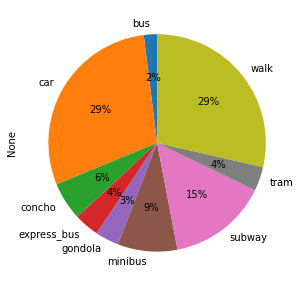

In [273]:
voykil = voy.apply(
    lambda c: c * distributed.euclidean.set_index(
    ['origin', 'destination']).sort_index()['km']
)


s = voy.sum()[sorted(set(sm.mode_nests.index) - set(sm.mode_nests['root']))]
plot = s.plot(
    kind='pie', 
    autopct='%1.0f%%',
    shadow=False,
    startangle=90, figsize=[5, 5])
plot.set_aspect('equal')

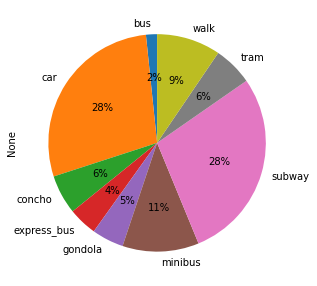

In [274]:
s = voykil.sum()[sorted(set(sm.mode_nests.index) - set(sm.mode_nests['root']))]
plot = s.plot(
    kind='pie', 
    autopct='%1.0f%%',
    shadow=False,
    startangle=90, figsize=[5, 5])
plot.set_aspect('equal')

In [275]:
s = voykil.sum()[sorted(set(sm.mode_nests.index) - set(sm.mode_nests['root']))]

# Assignment

In [276]:
sm.car_los['path'] = sm.car_los['path'].apply(tuple)
sm.pt_los['path'] = sm.pt_los['path'].apply(tuple)
sm.los['path'] = sm.los['path'].apply(tuple)

## PT

# segmented assignment

In [277]:
sm.step_assignment(boarding_links=True, alightings=True, transfers=True, road=True, segmented=False)

In [278]:
sm.road_links.loc[53982]

index                                                        53982
a                                              osm_node_1864096701
b                                              osm_node_2295336584
length                                                   47.330829
geometry         LINESTRING (393513.6355091452 2047148.77479883...
capacity                                                      5000
time                                                     14.199249
toll                                                             0
speed                                                         12.0
(volume, car)                                             6.791052
(volume, pt)                                            692.537936
Name: 53982, dtype: object

In [279]:
links = sm.links#.loc[sm.links['route_type'] == 'subway']
links = sm.links.loc[sm.links['volume'] > 0]
links['label'] = ''

In [280]:
links['volume'].max()

12558.940293021637

In [281]:
sm.road_links['volume'] = sm.road_links[('volume', 'pt')]

In [282]:
df = sm.links
df = df.loc[df['volume'] > 0]

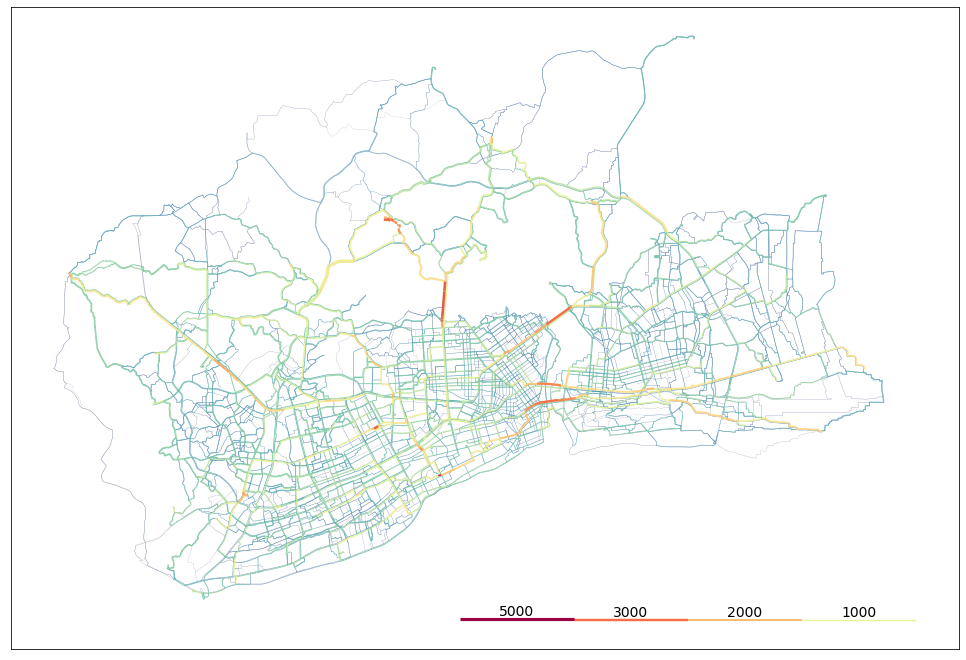

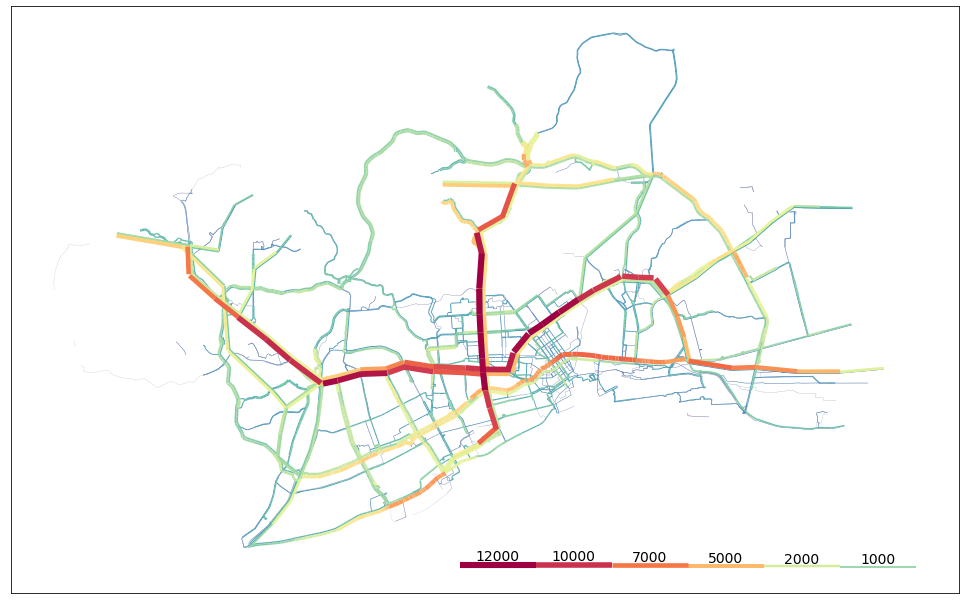

In [283]:
if manual:
    import matplotlib.pyplot as plt
    from syspy.syspy_utils import data_visualization as dv
    spectral = list(reversed(
        ['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b',
         '#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2']))

    fig, ax = plt.subplots(figsize=[17, 15])
    lv = (5000,3000, 2000, 1000)
    df = sm.road_links
    df['volume'] = df[('volume', 'car')]
    df = df.dropna(subset=['volume'])

    plot = dv.bandwidth(
        df, value_column='volume', power=0.5, max_value=lv[0], legend_values=lv,
        legend_length=0.5, label_column='label', max_linewidth_meters=100,
        cmap=spectral,
        label_kwargs={'size':14, 'color':'black'}, ax=ax
    )

    lv = (12000,10000, 7000,5000, 2000, 1000)
    fig, ax = plt.subplots(figsize=[17, 15])
    infra_links = sm.links.loc[sm.links.road_length.isnull()]

    sm.road_links['volume'] = sm.road_links[('volume', 'pt')]
    df = pd.concat([infra_links, sm.road_links])
    df['volume'] = df['volume'].fillna(0)
    df = df.loc[df['volume'] > 0]

    plot = dv.bandwidth(
        df, value_column='volume', power=0.5, max_value=lv[0],legend_values=lv,
        legend_length=0.5, label_column='label', max_linewidth_meters=200,
        #geographical_bounds=list(raster_montreal.bounds),
        cmap=spectral,
        label_kwargs={'size':14, 'color':'black'}, ax=ax
    )

In [284]:
sm.pt_los = sm.los.loc[sm.los['route_type'] != 'car']
sm.to_zip(quetzal_path + 'model/' +scenario + '/assigned.zip', omitted_attributes=['pt_los', 'car_los'])

od: 100%|██████████| 35/35 [00:10<00:00,  3.40it/s]              
